In [1]:
!pip install tensorflow==2.0.0b1
!pip install SimpleITK
import tensorflow as tf
assert tf.__version__=='2.0.0-beta1'
# DON'T use the magic %tensorflow_version 2.0, it will load the stable version which could alter the model output.

/Users/emanuel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/emanuel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/emanuel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/emanuel/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

In [2]:
print(tf.__version__)
import matplotlib.pyplot as plt
import dataset_helpers
import os
import numpy as np

2.0.0-beta1
No GPU found, model running on CPU


In [3]:
BATCH_SIZE = 32

In [4]:
def get_feature_description(modalities):

    feature_description =lambda mod : {
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),
        
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),

                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),
        
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),        
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),
        
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),

                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),

                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),                            
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),        
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),
                          }
    features = {}
    for mod in modalities:
        features.update(feature_description(mod))
    return features

In [5]:
use_gzip_compression = True

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=BATCH_SIZE, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './datasets/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset

    # You should generally cache after loading and preprocessing the data, 
    # but before shuffling, repeating, batching and prefetching”
    dataset = dataset.cache() if cache else dataset
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset

    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
  
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [6]:
os.listdir('.')

['dataset_helpers.py',
 '.DS_Store',
 'DeepMRI.py',
 'generated_images',
 'datasets',
 'models',
 '__pycache__',
 'models_GAN',
 'SegAN_IO_arch.py',
 '.ipynb_checkpoints',
 'SeganCATonColab.ipynb']

In [7]:
def load_datasets():
    validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], shuffle=False)
    training = load_dataset('brats2015_training_crop_mri', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], shuffle=True)
    testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], shuffle=False)
    return training, validation , testing

In [8]:
training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

modalities = ['MR_T1_mri', 'MR_T2_mri', 'MR_T1c_mri', 'MR_Flair_mri', 'OT_mri']

In [9]:
# PROCESSING IMAGES IN THE BATCH
def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (32, 180, 180))
    paddings = tf.constant([[0, 0], [38, 38], [38, 38]])
    batch = tf.pad(batch, paddings, "CONSTANT")
    batch = tf.expand_dims(batch, axis=3)
    return batch

In [10]:
# this method was tested to work with 5, 7 and 32 images.

def plot_images_new(*args, gen_t1): 
    
    if len(args) == 2:
        display_list = [args[0], args[1]]
        title = [r'${T_{1c}}$', r'$\mathit{T_{1c\ tumor\ area}}$']
        figsize = (7, 4)    
    elif len(args) == 3:
        display_list = [args[0], args[1], args[2]]
        title = [r'${T_{1c}}$', r'$\mathit{Ground\ Truth}$', r'$\mathit{Segmentation}}$']
        figsize = (10, 5)
    elif len(args) == 4:
        display_list = [args[0], args[1], args[2], args[3]]
        title = [r'$\mathit{T_{1}}$', r'$\mathit{T_{2}}$', r'$\mathit{T_{1c}}$', r'$\mathit{T_{2flair}}$']
        figsize = (12, 6)
    elif len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]]
        title = [r'${T_{1c}}$', r'$\mathit{Ground\ Truth}$', r'$\mathit{Segmentation}}$', r'$\mathit{Prediction}}$', r'$\mathit{Segmentation\ pred}}$']
        figsize = (14, 7)

    elif len(args) == 6:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5]]
        if gen_t1:
            title = ['T2', 'T1c', 'Tflair', 'T1 - ground Truth', 'T1 pix2pix prediction', 'T1 MI-GAN prediction']
        else:
            title = ['T1', 'T1c', 'Tflair', 'T2 - ground Truth', 'T2 pix2pix prediction', 'T2 MI-GAN prediction']
        figsize = (20, 6)

    elif len(args) == 7:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6]]
        if gen_t1:
            title = ['T2', 'T1c', 'Tflair', 'T1 - ground Truth', 'T1 pix2pix prediction', 'T1 MI-GAN prediction', 'T1 MI-pix2pix prediction']
        else:
            title = ['T1', 'T1c', 'Tflair', 'T2 - ground Truth', 'T2 pix2pix prediction', 'T2 MI-GAN prediction', 'T2 MI-pix2pix prediction']
        figsize = (21, 8)

    elif len(args) == 9:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8]]
        if gen_t1:
            title = ['T2', 'T1c', 'Tflair', 'T1 - ground Truth', 'T1 pix2pix prediction', 'T1 MI-GAN prediction', 'GT Tumor', 'pix2pix pred tumor', 'MI-GAN pred tumor']
        else:
            title = ['T1', 'T1c', 'Tflair', 'T2 - ground Truth', 'T2 pix2pix prediction', 'T2 MI-GAN prediction', 'GT Tumor', 'pix2pix pred tumor', 'MI-GAN pred tumor']

        figsize = (23, 12)

    elif len(args) == 11:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9], args[10]]
        if gen_t1:
            title = ['T2', 'T1c', 'Tflair', 'T1 - ground Truth', 'T1 pix2pix prediction', 'T1 MI-GAN prediction', 'T1 MI-pix2pix prediction','GT Tumor', 'pix2pix pred tumor', 'MI-GAN pred tumor', 'MI-pix2pix pred tumor']
        else:
            title = ['T1', 'T1c', 'Tflair', 'T2 - ground Truth', 'T2 pix2pix prediction', 'T2 MI-GAN prediction', 'T2 MI-pix2pix prediction','GT Tumor', 'pix2pix pred tumor', 'MI-GAN pred tumor', 'MI-pix2pix pred tumor']

        figsize = (30, 15)
    
    for j in range(1):
        plt.figure(j , figsize)
        n = 0
        for i in range(len(args)):    # batch size is different from 10, but let's show just 10 images.
            n += 1
            plt.subplot(1, len(args), n).title.set_text(title[i])
            plt.subplot(1, len(args), n).title.set_size(16)
            plt.imshow(tf.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')
        plt.subplots_adjust(left=0, bottom=None, right=0.75, top=None, wspace=0.0, hspace=None)
        plt.show()

In [11]:
def take_images_from_raw_pat(raw_record, ot=False):
    patient = raw_record['MR_T2_patient']
    patient_grade = raw_record['MR_T2_patient_grade']
    modalities = ['MR_T1_mri', 'MR_T2_mri', 'MR_T1c_mri', 'MR_Flair_mri', 'OT_mri']
    t1, t2, t1c, tflair = raw_record[modalities[0]], raw_record[modalities[1]], raw_record[modalities[2]], raw_record[modalities[3]]
    t1 = process_batch(t1)
    t2 = process_batch(t2)
    t1c = process_batch(t1c)
    tflair = process_batch(tflair)
    if ot:      # if ot is true, I'll retrieve also the segmentation from the raw_record
        segmentation = process_batch(raw_record[modalities[4]])
        return t1, t2, t1c, tflair, segmentation, patient, patient_grade
    return t1, t2, t1c, tflair, patient, patient_grade
    
# final shape will be (bs, 256, 256, 1): now the batch is ready to be fed to the GAN

def resize_with_crop(*args): # possibile arguments: input, gt, prediction and maybe the segmentation

    image0 = tf.image.resize_with_crop_or_pad(args[0], 155, 194)
    image1 = tf.image.resize_with_crop_or_pad(args[1], 155, 194)
    image2 = tf.image.resize_with_crop_or_pad(args[2], 155, 194)
    image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
    if len(args) == 5:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        return image0, image1, image2, image3, image4
    if len(args) == 7:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        image6 = tf.image.resize_with_crop_or_pad(args[6], 155, 194)
        return image0, image1, image2, image3, image4, image5, image6
    if len(args) == 8:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        image6 = tf.image.resize_with_crop_or_pad(args[6], 155, 194)
        image7 = tf.image.resize_with_crop_or_pad(args[7], 155, 194)
        return image0, image1, image2, image3, image4, image5, image6, image7
    return image0, image1, image2, image3

In [12]:
import warnings
warnings.filterwarnings("ignore")

0


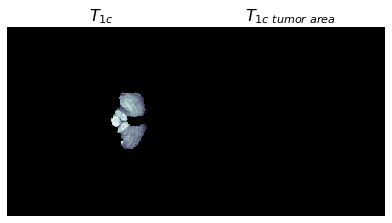

1


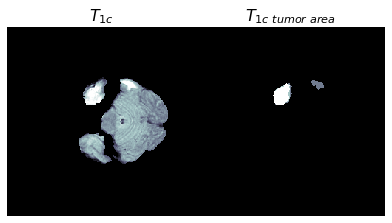

2


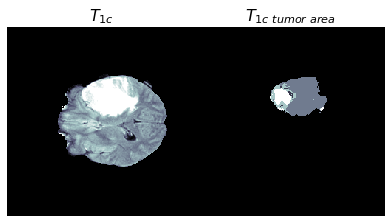

In [13]:
evaluate_tumor_area = False
idx = 0
for raw_record in testing.take(3):
    print(idx)
    t1, t2, t1c, tflair, ground_truth, patient, patient_grade = take_images_from_raw_pat(raw_record, ot=True)
    #t1c_cr, segmentation_cr, t2_cr, t2 = resize_with_crop(t1c, segmentation, t2, t2)
    # preparing the input to the generator
    
    plot_images_new(tflair, ground_truth, gen_t1=True)
    idx +=1

In [14]:
# Now that I loaded images from the dataset, let's load my h5 model in order to generate new T1c images

# I'll use the pix2pix model generating T1c from T1:


In [34]:
from DeepMRI import DeepMRI
import SegAN_IO_arch as arch

model_name = 'Segan_IO_TF2_brats_on_T1c' # The name of the folder inside './models' containing the model to load
mri_channels = 1 # input channels (modalities)

gan = DeepMRI(batch_size=32, size=256, mri_channels=mri_channels, model_name=model_name)
gan.build_model(load_model='last', seed=1234567890, arch=arch)

Using architecture: SegAN_IO_arch
Latest Checkpoint is: models/Segan_IO_TF2_brats_on_T1c/best_dice_score_1011-48
Loaded model from: last, next epoch: 1012


In [47]:
segmentation = gan.generator(t1c, training=False)
segmentation.shape

TensorShape([32, 256, 256, 1])

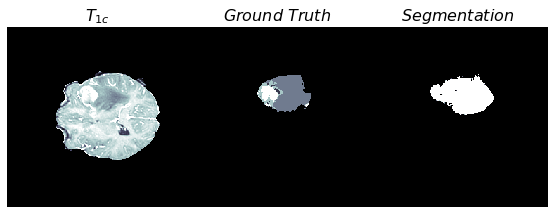

In [48]:
plot_images_new(t1c, ground_truth, segmentation, gen_t1=True)

In [37]:
outfile = './generated_images/batch_from_pix2pix_t1c.npy'
prediction1 = np.load(outfile)

outfile = './generated_images/batch_from_MIGAN_t1c.npy'
prediction2 = np.load(outfile)

outfile = './generated_images/batch_from_MIpix2pix_t1c.npy'
prediction3 = np.load(outfile)

In [38]:
segmentation_pred1 = gan.generator(prediction1, training=False)
segmentation_pred2 = gan.generator(prediction2, training=False)
segmentation_pred3 = gan.generator(prediction3, training=False)

## pix2pix

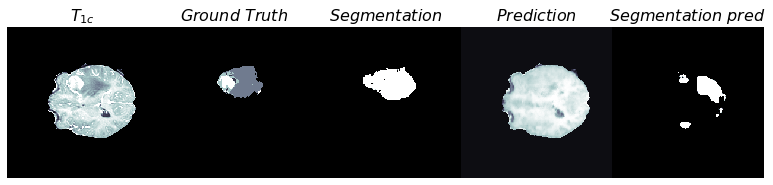

In [49]:
plot_images_new(t1c, ground_truth, segmentation, prediction1, segmentation_pred1, gen_t1=True)

## MI GAN

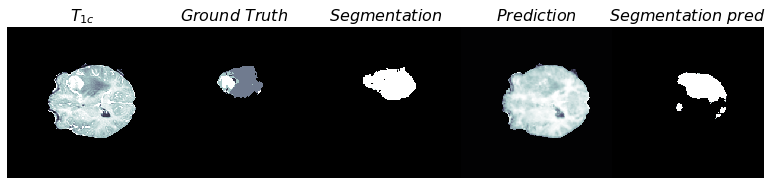

In [50]:
plot_images_new(t1c, ground_truth, segmentation, prediction2, segmentation_pred2, gen_t1=True)

## MI pix2pix

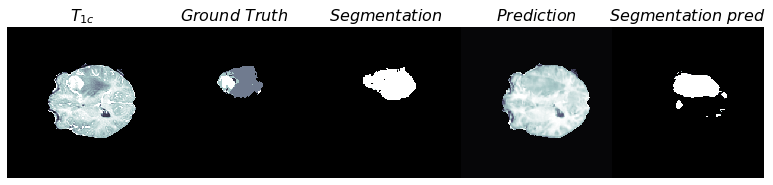

In [51]:
plot_images_new(t1c, ground_truth, segmentation, prediction3, segmentation_pred3, gen_t1=True)

In [45]:
def mean_rescale(x, xmin, xmax):
    mean = tf.reduce_mean(x)
    return ((x-mean)/(xmax-xmin)) 

def mean_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = mean_rescale(image[i], min_value, max_value)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

In [46]:
image = prediction1
for i in range(BATCH_SIZE):
    
    max_value = tf.math.reduce_max(image[i])
    min_value = tf.math.reduce_min(image[i])
    print(min_value.numpy(), max_value.numpy(), (max_value-min_value).numpy())
    

-0.06600221 0.9999995 1.0660018
-0.056327127 0.99999833 1.0563254
-0.034336112 0.99999976 1.0343359
-0.04050849 1.0 1.0405085
-0.028368844 0.99999994 1.0283688
-0.029546557 0.9999998 1.0295464
-0.028337518 0.99999994 1.0283375
-0.032808222 1.0 1.0328082
-0.024307588 0.9999996 1.0243071
-0.030431032 1.0 1.030431
-0.03932754 0.9999999 1.0393274
-0.049440097 0.99999976 1.0494399
-0.040051345 0.9999999 1.0400512
-0.042026617 0.99999994 1.0420265
-0.033845194 1.0 1.0338452
-0.03884694 1.0 1.038847
-0.062190417 0.9999992 1.0621897
-0.03837962 0.9999999 1.0383795
-0.025954505 0.9999999 1.0259544
-0.031839408 0.99999994 1.0318394
-0.032675844 0.99999714 1.032673
-0.06820318 0.99999666 1.0681999
-0.023764824 0.99999994 1.0237647
-0.03416707 0.99999976 1.0341668
-0.031085508 1.0 1.0310855
-0.039270636 1.0 1.0392706
-0.028759003 1.0 1.028759
-0.033346158 1.0 1.0333462
-0.029391974 0.99999994 1.0293919
-0.02782905 0.99999994 1.0278289
-0.037823036 0.99999994 1.037823
-0.05137711 0.99998826 1.05136

In [47]:
image = mean_normalize(prediction1)
for i in range(BATCH_SIZE):
    
    max_value = tf.math.reduce_max(image[i])
    min_value = tf.math.reduce_min(image[i])
    print(min_value.numpy(), max_value.numpy(), (max_value-min_value).numpy())

-0.23735383 0.76264614 1.0
-0.23198263 0.7680174 1.0
-0.21852738 0.7814726 1.0
-0.22426648 0.7757335 0.99999994
-0.21667211 0.7833279 1.0
-0.21759287 0.78240716 1.0
-0.21630311 0.7836969 1.0
-0.22076204 0.779238 1.0
-0.21503818 0.7849619 1.0
-0.21887429 0.7811257 1.0
-0.22626607 0.7737339 1.0
-0.23360911 0.7663908 0.9999999
-0.22599635 0.7740037 1.0
-0.22697383 0.7730262 1.0
-0.22157536 0.7784247 1.0
-0.22500502 0.77499497 1.0
-0.2408092 0.75919074 0.99999994
-0.22302695 0.776973 0.99999994
-0.21092437 0.7890756 1.0
-0.21445063 0.78554934 1.0
-0.21431386 0.78568614 1.0
-0.23903616 0.7609638 0.99999994
-0.20498088 0.79501915 1.0
-0.21178213 0.7882179 1.0
-0.20755045 0.79244953 1.0
-0.21195066 0.78804934 1.0
-0.20136692 0.7986331 1.0
-0.2011259 0.7988741 1.0
-0.19328502 0.806715 1.0
-0.18918306 0.810817 1.0
-0.19380648 0.80619353 1.0
-0.20075056 0.7992494 1.0


In [48]:
image2 = mean_normalize(t1c)
for i in range(BATCH_SIZE):
    
    max_value = tf.math.reduce_max(image2[i])
    min_value = tf.math.reduce_min(image2[i])
    print(min_value.numpy(), max_value.numpy(), (max_value-min_value).numpy())

-0.17391613 0.8260839 1.0
-0.17375438 0.8262456 1.0
-0.17607057 0.8239294 1.0
-0.17526644 0.82473356 1.0
-0.17536244 0.82463753 1.0
-0.17426452 0.82573545 1.0
-0.17520468 0.8247953 1.0
-0.17583607 0.8241639 1.0
-0.17680168 0.8231983 1.0
-0.1782634 0.8217366 1.0
-0.17892194 0.82107806 1.0
-0.17945567 0.82054436 1.0
-0.17989866 0.8201013 1.0
-0.1802126 0.8197874 1.0
-0.1803868 0.8196132 1.0
-0.18015778 0.8198422 1.0
-0.17937839 0.8206216 1.0
-0.17860153 0.8213985 1.0
-0.17699587 0.8230041 1.0
-0.17536569 0.8246343 1.0
-0.17438927 0.82561076 1.0
-0.1742754 0.8257246 1.0
-0.17344362 0.8265564 1.0
-0.17340374 0.82659626 1.0
-0.17226917 0.82773083 1.0
-0.17031881 0.82968116 1.0
-0.16698062 0.8330194 1.0
-0.16360047 0.83639956 1.0
-0.16000298 0.83999705 1.0
-0.15676117 0.84323883 1.0
-0.1531156 0.84688437 1.0
-0.15024215 0.84975785 1.0


In [49]:
segmentation_pred1 = gan.generator(image, training=False)

In [50]:
segmentation_pred2 = gan.generator(image2, training=False)

Segmentation of original image normalized and segmentation of the prediction normalized

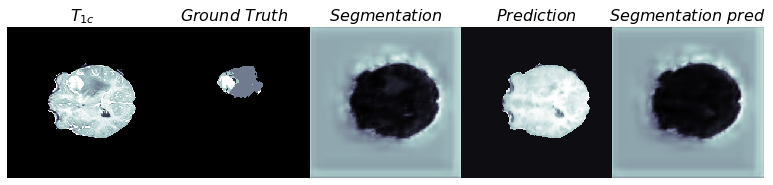

In [51]:
plot_images_new(image2, ground_truth, segmentation_pred2, image, segmentation_pred1, gen_t1=True)